In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import time
import matplotlib
from multiprocessing import Pool
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from matplotlib import rc
from screm import Screm


## Functions

* **delta_t(l)**
    * Computes transition time using the equation $ \Delta t = -\frac{\ln\sigma}{\lambda} $ where $ \sigma $ is a uniform random variable, and $ \lambda $ is the reaction coefficient, which is computed as $ \lambda = k_i \Pi_{\rm j=1}^{\rm n} [N_j] $ for reaction $i$ where $k_i$ is the rate of that reaction and $[N_j]$ is the number of molecules of reactant j for all $(j=1\rightarrow n)$ in reaction $i$.
    
    
   
* **simulate_reactions(v, reaction_net, iterations, verbose=False)**
    * Simulates stochastic chemical reactions within a defined reaction network, given initial molecule counts vector $v$ and a defined number of iterations using a continuous markov process. 
    * Output:
        * T: array of each transition time
        * V: A matrix containing the number of molecules for each reactant for each transition in the markov process.
        * I: final number of iterations
    
    
* **plot_simulation(T,V,I, reaction_net, metabolites="all", figsize=(7,3), dpi=170)**
    * Plots the number of molecules versus in silico time for all specified metabolites in a defined reaction network.
   
   
* **plot_simulations_violin(model_results, init, ax, datatype="iter", poly=1)**
    * For a set of repeated simulations with the same conditions, plot violin plots of time to simulation convergence (or number of iterations to convergence) as well as a best fit line.
    
    
* **plot_residuals(model_results, init, ax, datatype="iter", poly=1)**
    * Plots the difference between the best fit polynomail line and the actual data points.

In [2]:
def delta_t(l):
    return -math.log(np.random.uniform())/l

In [11]:
def simulate_reactions(v, reaction_net, iterations, verbose=False):
    
    start_time = time.time()
    np.random.seed()
    A = reaction_net["stoichiometry"]
    reactants = reaction_net["reactants"]
    reaction_rates = reaction_net["rates"]
    reaction_relations = reaction_net["relations"]
    
    times = [0]
    
    for i in range(iterations):
        
        #get relevant reactants
        reactant_indices = [j for j, item in enumerate(np.ravel(v[-1])) if item !=0]
        cur_reactants = [reactants[j] for j in reactant_indices]
        cur_reactant_amounts = {r: v[-1,j] for j, r in enumerate(reactants)}
        
        #compute possible next reactions
        next_reactions = [rxn for rxn, req in reaction_relations.items() if set(req).issubset(set(cur_reactants))]
        
        #exit if we have there are no possible next reactions:
        if len(next_reactions) == 0:
            break
                
        #compute rxn coefficients for possible next reactions:
        rxn_rates = {rxn: reaction_rates[rxn]*math.exp(sum(map(math.log,[v[-1,reactants.index(r)] for r in reaction_relations[rxn]]))) for rxn in next_reactions}
        
        #compute delta ts:
        dt = {rxn: delta_t(rate) for rxn, rate in rxn_rates.items()}
        
        #find fastest dt:
        while 1:
            next_state = min(dt, key=dt.get)
            update_v = v[-1]+A[:,next_state].T
            if -1 not in np.ravel(update_v):
                break
            else:
                del dt[next_state]
        
        #update times:
        times.append(times[-1] + dt[next_state])
        
        #update v:
        v = np.vstack((v, update_v))
        
        if verbose == True:
            print("v[-1]:", np.ravel(v[-1]))
            print("cur reactants", cur_reactants)
            print("cur_reactant_amounts", cur_reactant_amounts)
            print("next reactions", next_reactions)
            print("rxn_rates", rxn_rates)
            print("dt:", dt)
            print("fastest dt:", min(dt, key=dt.get))
            print()
    end_time = time.time()
    #print("time elapsed: {}".format(end_time-start_time))
    return times, v, i+1



In [4]:
def plot_simulation(T,V,I, reaction_net, metabolites="all", figsize=(7,3), dpi=170):
    
    A = reaction_net["stoichiometry"]
    reactants = reaction_net["reactants"]
    reaction_rates = reaction_net["rates"]
    reaction_relations = reaction_net["relations"]
    
    fig, axes = plt.subplots(1,1,figsize=figsize, dpi=dpi)

    cm = plt.get_cmap('jet')
    color_dict = {r: cm(1.*j/A.shape[0]) for j, r in enumerate(reactants)}
    
    #which reactants do we want to plot?
    if metabolites != "all":
        plot_metabolites = [reactants.index(m) for m in metabolites]
    else:
        plot_metabolites = [i for i in range(A.shape[0])]
        metabolites = [r for r in reactants]
    
    for j in plot_metabolites:
        axes.plot(T, np.ravel(V[:,j]), color=color_dict[reactants[j]])
    axes.set_title("{} iterations".format(I))
    axes.spines['top'].set_visible(False)
    axes.spines['right'].set_visible(False)
    axes.set_xticks([])
    axes.set_xlabel("time")
    axes.set_ylabel("molecules")
    axes.legend(metabolites, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    

In [15]:
def plot_simulations_violin(model_results, init, ax, datatype="iter", poly=1):
    
    if datatype == "iter":
        data = [[I for T,V,I in model_results[i]] for i in range(len(init))]
        means = [np.mean(i) for i in data]
    elif datatype == "time":
        data = [[T[-1] for T,V,I in model_results[i]] for i in range(len(init))]
        means = [np.mean(t) for t in data]

    violin = ax.violinplot(data, vert=True, showmeans=True);
    for i, v in enumerate(violin['bodies']):
        v.set_edgecolor('k')
        v.set_alpha(0.7)

    # change the line color from blue to black
    for partname in ('cbars','cmins','cmaxes', 'cmeans'):
        vp = violin[partname]
        vp.set_edgecolor('k')
        vp.set_linewidth(1)

    #draw best fit linear line:
    z, residuals, _, _, _ = np.polyfit([i for i in range(1, len(init)+1)], means, poly, full=True)
    fit = np.polyval(z, [i for i in range(1,len(init)+1)])
    ax.plot([i for i in range(1, len(init_glucose)+1)], fit)
    r2 = r2_score(fit, means)

    #format spines:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    #label things:
    if datatype == "iter":
        ax.set_ylabel("iterations to convergence")
    elif datatype == "time":
        ax.set_ylabel("time (in silico)")
    ax.set_yticks([])
    ax.set_xlabel("initial glucose molecules")
    ax.set_xticks([2*i-1 for i in range(1,11)])
    ax.set_xticklabels([g for i, g in enumerate(init_glucose) if i % 2 == 0])
    ax.annotate("r-squared:{}".format(str(r2)[:5]),
                xy=(1, 0), xycoords='axes fraction',
                xytext=(-20, 20), textcoords='offset pixels',
                horizontalalignment='right',
                verticalalignment='bottom')


In [16]:
def plot_residuals(model_results, init, ax, datatype="iter", poly=1):
    
    if datatype == "iter":
        data = [[I for T,V,I in model_results[i]] for i in range(len(init))]
        means = [np.mean(i) for i in data]
    elif datatype == "time":
        data = [[T[-1] for T,V,I in model_results[i]] for i in range(len(init))]
        means = [np.mean(t) for t in data]
    
    #compute best fit line:
    z, residuals, _, _, _ = np.polyfit([i for i in range(1, len(init)+1)], means, poly, full=True)
    fit = np.polyval(z, [i for i in range(1,len(init)+1)])
    r2 = r2_score(fit, means)
    
    ax.scatter([i for i in range(1,len(init)+1)],fit - means)

    #format:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylabel("residuals")
    ax.set_yticks([])
    ax.set_xlabel("initial glucose molecules")
    ax.set_xticks([2*i-1 for i in range(1,11)])
    ax.set_xticklabels([g for i, g in enumerate(init) if i % 2 == 0])
   


## Stochastic bioChemical REaction network simulations with continuous Markov processes

We aim to investigate the glycolysis reaction cascade using a stochastic in silico framework. For all subsequent models, we begin with constructing a reaction network using the following steps:

1. Create a list of reactants to be modeled in the reaction network.
2. Construct a stoichiometry matrix for the reaction, in which each row is a reactant, and each column is a reaction.
3. Create a dictionary where the key is the reaction number, and the value is a list of reactants that that reaction depends on. For example, the first reaction in glycolysis depends on presence of Glucose, so ```reaction_relation[0] = ["Glucose"]```
4. Perform a literature search to find reaction rates for all relecant reactions.
5. Compile these features into a reaction_net dictionary object.


## Simple model: no flux, no ATP

A simple biochemical reaction network for the glycolysis reaction cascade is constructed as follows:
* Only model quantities of the reactants and products for the reactions of glycolysis.

* Define a stoichiometry matrix of size $17 \times 11$, 17 reactions and 11 reactants. We have 17 reactions in this model despite textbooks such as Lehninger Principles of Biochemistry considering 10 reactions of glycolysis, because we are treating forward and reverse reactions separately in this framework

* We define an initial molecule count vector $v$ such that we only start with molecules of glucose.

* There is no flux in or out of the system.

* We are not considering the requirements of ADP, ATP for these reactions to proceed.

* We assume enzyme saturation.

In [34]:
# reaction 7 is unidiretional, from lehninger
#                 r1  r2     r-2  r3     r4     r-4    r5     r-5   r6      r6-1    r7    r8     r8-1 r9   r-9   r10
reaction_rates = [30, 2.637, 2.637, 0.047, 0.045, 0.045, 0.379, 0.15, 0.0098, 0.0098, 0.53, 0.733, 0.733, 0.5, 0.04, 21 ]
reactants = [
    "Glucose", "G6P", "F6P", "F1,6BP", "GADP", "DHAP",
    "1,3BPG", "3PG", "2PG", "PEP", "Pyruvate"]
reaction_relations = {
    0: ["Glucose"],
    1: ["G6P"],
    2: ["F6P"],
    3: ["F6P"],
    4: ["F1,6BP"],
    5: ["GADP", "DHAP"],
    6: ["DHAP"],
    7: ["GADP"],
    8: ["GADP"],
    9:["1,3BPG"],
    10:["1,3BPG"],
    11:["3PG"],
    12:["2PG"],
    13:["2PG"],
    14:["PEP"],
    15:["PEP"]
}
A = np.matrix(
    [[-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],  # Glucose
    [1,-1,1,0,0,0,0,0,0,0,0,0,0,0,0,0],   # G6P
    [0,1,-1,-1,0,0,0,0,0,0,0,0,0,0,0,0],  # F6P
    [0,0,0,1,-1,1,0,0,0,0,0,0,0,0,0,0],   # F1,6BP
    [0,0,0,0,1,-1,1,-1,-1,1,0,0,0,0,0,0], # GADP
    [0,0,0,0,1,-1,-1,1,0,0,0,0,0,0,0,0],  # DHAP
    [0,0,0,0,0,0,0,0,1,-1,-1,0,0,0,0,0],  # 1,3BPG
    [0,0,0,0,0,0,0,0,0,0,1,-1,1,0,0,0],   # 3PG
    [0,0,0,0,0,0,0,0,0,0,0,1,-1,-1,1,0],  # 2PG
    [0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1,-1],  # PEP
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]]    # Pyruvate
)

reaction_net_1 = {"reactants": reactants,
                  "rates": reaction_rates,
                  "relations": reaction_relations,
                  "stoichiometry": A}

**Initial molecule counts for simple no flux no ATP model**

* The initial number of molecules of glucose is $I_G = 500$
* All other reactants start at $I_j = 0$ for all reactants $(j=2\rightarrow11)$

In [44]:
# test to see if screm module works:
scr = Screm()

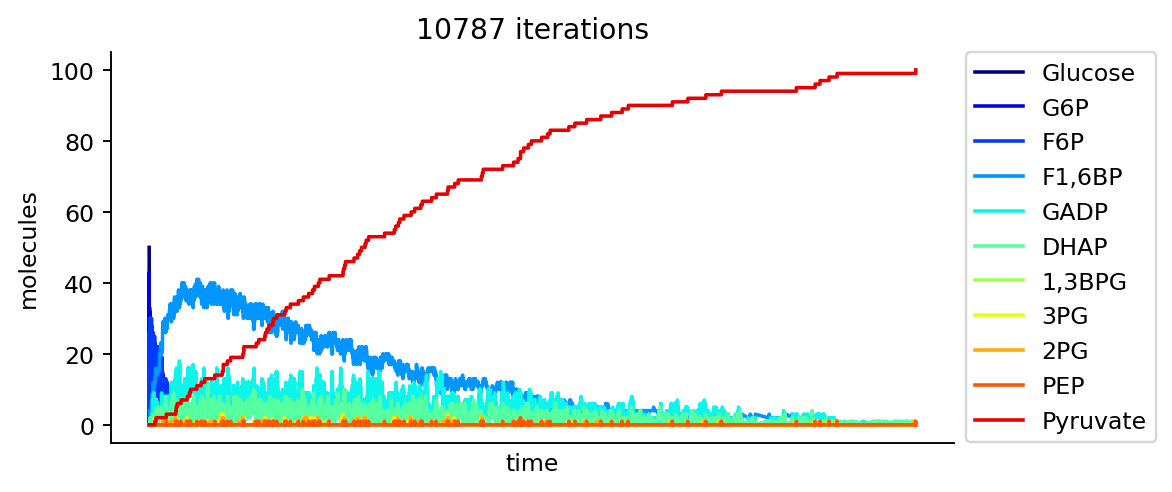

In [45]:
iters = 200000
initial = np.matrix(np.array([50,0,0,0,0,0,0,0,0,0,0]))
T,V,I = scr.simulate_reactions(initial, reaction_net_1, iters)
scr.plot_simulation(T, V, I, reaction_net_1)

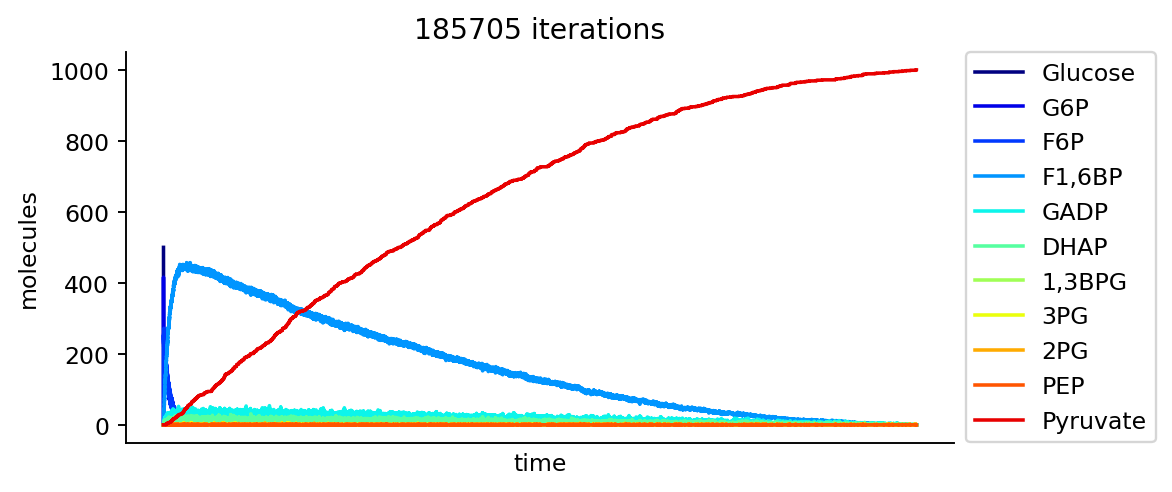

In [37]:
iters = 200000
initial = np.matrix(np.array([500,0,0,0,0,0,0,0,0,0,0]))
T,V,I = simulate_reactions(initial, reaction_net_1, iters)
plot_simulation(T, V, I, reaction_net_1)

**We make the following observations based on this simulation**

* Starting with $I_G = 500 $, we obtain a final value of pyruvate $ N_{\rm pyruvate} = 2I_G = 1000$. Therefore, this model agrees with the net glycolysis reaction equation, which dictates that two molecules of pyruvate are produced for each molecule of glucose.

## Extend model to include ATP and ADP terms

After seeing that this model can successfully reproduce the conversion of glucose to pyruvate, we wish to complicate this model by defining a new chemical reaction network that takes ATP and ADP into account. The following figure from Lehninger Principles of Biochemistry describes the preparatory phase of glycolysis, in which two molecules of ATP are required for one molecule of glucose.

<img src="glyco1.png" alt="drawing" height="650" width="650"/>


Since ATP and ADP are essential to the proceudre of the glycolysis reaction, we wish to include these as reactants in our model. To do this, we simply need to define a new reaction network dictionary object, ensuring the reactants list contains ATP and ADP terms, and including the exchange of ATP and ADP in our stoichiometry matrix

In [38]:
# reaction 7 is unidiretional, from lehninger
#                 r1  r2     r-2  r3     r4     r-4    r5     r-5   r6      r6-1    r7    r8     r8-1 r9   r-9   r10
reaction_rates = [30, 2.637, 2.637, 0.047, 0.045, 0.045, 0.379, 0.15, 0.0098, 0.0098, 0.53, 0.733, 0.733, 0.5, 0.04, 21 ]
reactants = [
    "Glucose", "G6P", "F6P", "F1,6BP", "GADP", "DHAP",
    "1,3BPG", "3PG", "2PG", "PEP", "Pyruvate", "ATP", "ADP"]
reaction_relations = {
    0: ["Glucose", "ATP"],
    1: ["G6P"],
    2: ["F6P"],
    3: ["F6P", "ATP"],
    4: ["F1,6BP"],
    5: ["GADP", "DHAP"],
    6: ["DHAP"],
    7: ["GADP"],
    8: ["GADP"],
    9:["1,3BPG"],
    10:["1,3BPG", "ADP"],
    11:["3PG"],
    12:["2PG"],
    13:["2PG"],
    14:["PEP"],
    15:["PEP", "ADP"]
}
A = np.matrix(
    [[-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],  # Glucose
    [1,-1,1,0,0,0,0,0,0,0,0,0,0,0,0,0],   # G6P
    [0,1,-1,-1,0,0,0,0,0,0,0,0,0,0,0,0],  # F6P
    [0,0,0,1,-1,1,0,0,0,0,0,0,0,0,0,0],   # F1,6BP
    [0,0,0,0,1,-1,1,-1,-1,1,0,0,0,0,0,0], # GADP
    [0,0,0,0,1,-1,-1,1,0,0,0,0,0,0,0,0],  # DHAP
    [0,0,0,0,0,0,0,0,1,-1,-1,0,0,0,0,0],  # 1,3BPG
    [0,0,0,0,0,0,0,0,0,0,1,-1,1,0,0,0],   # 3PG
    [0,0,0,0,0,0,0,0,0,0,0,1,-1,-1,1,0],  # 2PG
    [0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1,-1],  # PEP
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],    # Pyruvate
    [-1,0,0,-1,0,0,0,0,0,0,2,0,0,0,0,2],  # ATP
    [1,0,0,1,0,0,0,0,0,0,-2,0,0,0,0,-2]]  # ADP 
)

reaction_net_2 = {"reactants": reactants,
                  "rates": reaction_rates,
                  "relations": reaction_relations,
                  "stoichiometry": A}

## Initial conditions of the stochastic glycolysis reaction network model with ATP

Given the net Glycolysis reaction,

$ G + 2ATP \rightarrow 2Pyruvate + 4ATP $

it would make sense if we could simply inititialize the system with $ I_{\rm ATP} = 2I_G $.

However, due to the stochastic nature of how these simulated reactions are proceeding, we run into a problem where all of the ADP generated in the beginning of the Glycolysis reaction cascade could be exhausted in reaction 7, as seen in the following figure from Lehninger Principles of Biochemistry.

<img src="glyco.png" alt="drawing" height="650" width="650"/>

If this were the case, we would not see the full conversion of $ G + 2ATP \rightarrow 2Pyruvate + 4ATP $. We expect to observe full depletion of ADP molecules, and a subsequent halt of ATP and Pyruvate production. We run our stochastic reaction network model using the following initial conditions:

* $ I_G = 50 $ 
* $ I_{\rm ATP} = 2N_G = 100$ 
* $ T_{\rm max} = 2250$ (number of iterations)

All other metabolites have been initialized to zero molecules.

time elapsed: 0.059603214263916016 seconds


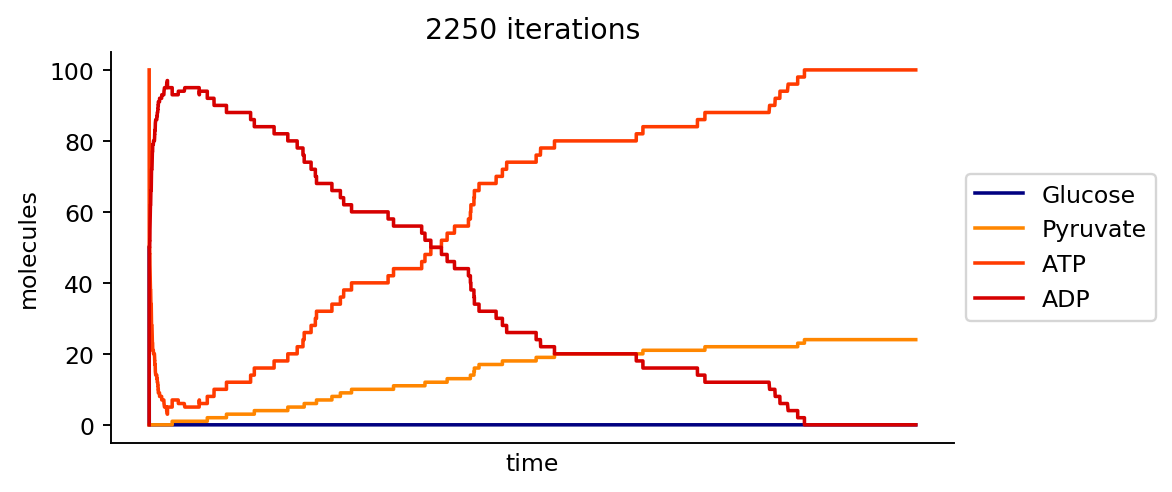

In [358]:
initial = np.matrix(np.array([50,0,0,0,0,0,0,0,0,0,0,100,0]))
iters = 2250
T, V, I = simulate_reactions(initial, reaction_net_2, iters)
plot_simulation(T,V,I, reaction_net_2, metabolites=["Glucose", "Pyruvate", "ATP", "ADP"])

**We make the following observations based on this simulation:**

* We do not observe a full conversion of glucose to pyruvate, $N_{\rm pyruvate} < 2I_G$

* At the start of the reaction, we see a rapid conversion of almost all of the ATP molecules into ADP, followed by a slower conversion back from ADP to ATP. As expected, we observe an exhaustion of the supply of ADP molecules, thus the final reaction $ PEP + 2ADP \rightarrow Pyruvate + 2ATP $ cannot proceed.

* The simulation is programmed to stop when the maximum number of iterations has occurred, or if there are no more possible reactions. In this case, the intermediate metabolites (not shown in the above plot) are fluctuating while glucose, pyruvate, ATP, and ADP remain stable.

In a real biological system, free ATP and ADP exist floating around the cell that were not directly created or destroyed as a consequence of this reaction network. Since we are not considering any flux of metabolites in or out of the reaction network, we can simply **initialize $ I_{\rm ADP} $ to some sufficiently large value**, representing a pool of ADP existing throughout the cell, such that our model fully converts $ I_G   \rightarrow N_{\rm pyruvate} = 2I_G$. 

Now, we run the stochastic reaction network model for the following initial conditions:

* $ I_G = 50 $ 
* $ I_{\rm ATP} = IN_G = 100$ 
* $ I_{\rm ADP} = IN_G = 300$
* $ T_{\rm max} = 10000$


time elapsed: 1.0762789249420166


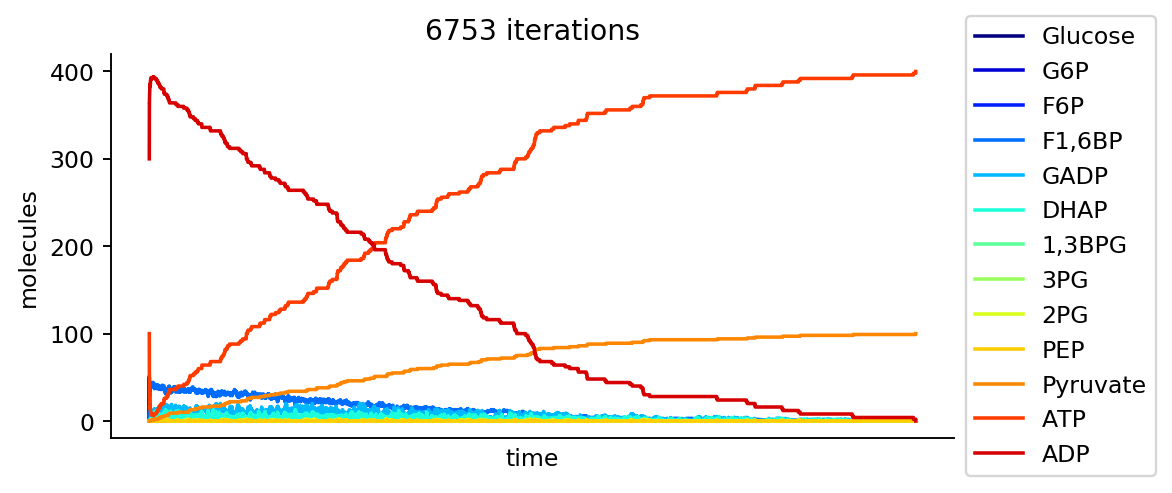

In [284]:
initial = np.matrix(np.array([50,0,0,0,0,0,0,0,0,0,0,100,300]))
iters = 10000
T, V, I = simulate_reactions(initial, reaction_net_2, iters )
plot_simulation(T,V,I, reaction_net_2)

**We make the following observations from this simulation:**

* The simulation terminated when there are no more possible reactions to proceed to, $ T_{sim} < T_{\rm max}$, thus we can say that this system has converged to a steady state.

* We observe the expected amount of pyruvate generated as dictated by the glycolysis net reaction, $ E_{\rm pyruvate} = N_{\rm pyruvate} = 2I_G$

* We observe a final amount of ATP generated eight times larger than expected based on the glycolysis net reaction. $ N_{\rm ATP} = 8I_G \neq E_{\rm ATP}$

* We observe a final amount of ATP equal to $ N_{\rm ATP} = I_{\rm ATP} + I_{\rm ADP} = 400$ and a final amount of ADP equal to $ N_{\rm ADP} = 0 $.

From our initial conditions, we expect to produce 100 molecules of pyruvate from 50 molecules of glucose. From reactions 7 and 10, as seen in the figure above from Lehninger, the expenditure of 4 ADP molecules is required to produce one pyruvate. Thus, for these initial conditions, we require 400 molecules of ADP in order to achieve the desired 100 molecules of pyruvate.

## Extend model to include flux of glucose, pyruvate, ATP and ADP

In a biological system, it 

In [39]:
# reaction 7 is unidiretional, from lehninger
#                 r1  r2     r-2  r3     r4     r-4    r5     r-5   r6      r6-1    r7    r8     r8-1 r9   r-9   r10
glucose_rate = 0.01
pyruvate_rate = 0.01
reaction_rates = [glucose_rate, 30, 2.637, 2.637, 0.047, 0.045, 0.045, 0.379, 0.15, 0.0098, 0.0098, 0.53, 0.733, 0.733, 0.5, 0.04, 21, pyruvate_rate ]
reactants = [
    "Glucose", "G6P", "F6P", "F1,6BP", "GADP", "DHAP",
    "1,3BPG", "3PG", "2PG", "PEP", "Pyruvate", "ATP", "ADP"]
reaction_relations = {
    0: [],
    1: ["Glucose", "ATP"],
    2: ["G6P"],
    3: ["F6P"],
    4: ["F6P", "ATP"],
    5: ["F1,6BP"],
    6: ["GADP", "DHAP"],
    7: ["DHAP"],
    8: ["GADP"],
    9: ["GADP"],
    10:["1,3BPG"],
    11:["1,3BPG", "ADP"],
    12:["3PG"],
    13:["2PG"],
    14:["2PG"],
    15:["PEP"],
    16:["PEP", "ADP"],
    17:["Pyruvate"]
}
A = np.matrix(
    [[1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],  # Glucose
    [0,1,-1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],   # G6P
    [0,0,1,-1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0],  # F6P
    [0,0,0,0,1,-1,1,0,0,0,0,0,0,0,0,0,0,0],   # F1,6BP
    [0,0,0,0,0,1,-1,1,-1,-1,1,0,0,0,0,0,0,0], # GADP
    [0,0,0,0,0,1,-1,-1,1,0,0,0,0,0,0,0,0,0],  # DHAP
    [0,0,0,0,0,0,0,0,0,1,-1,-1,0,0,0,0,0,0],  # 1,3BPG
    [0,0,0,0,0,0,0,0,0,0,0,1,-1,1,0,0,0,0],   # 3PG
    [0,0,0,0,0,0,0,0,0,0,0,0,1,-1,-1,1,0,0],  # 2PG
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1,-1,0],  # PEP
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1],   # Pyruvate
    [0,-1,0,0,-1,0,0,0,0,0,0,2,0,0,0,0,2,0],  # ATP
    [0,1,0,0,1,0,0,0,0,0,0,-2,0,0,0,0,-2,0]]  # ADP 
)

reaction_net_3 = {"reactants": reactants,
                  "rates": reaction_rates,
                  "relations": reaction_relations,
                  "stoichiometry": A}


time elapsed: 0.06590533256530762 seconds


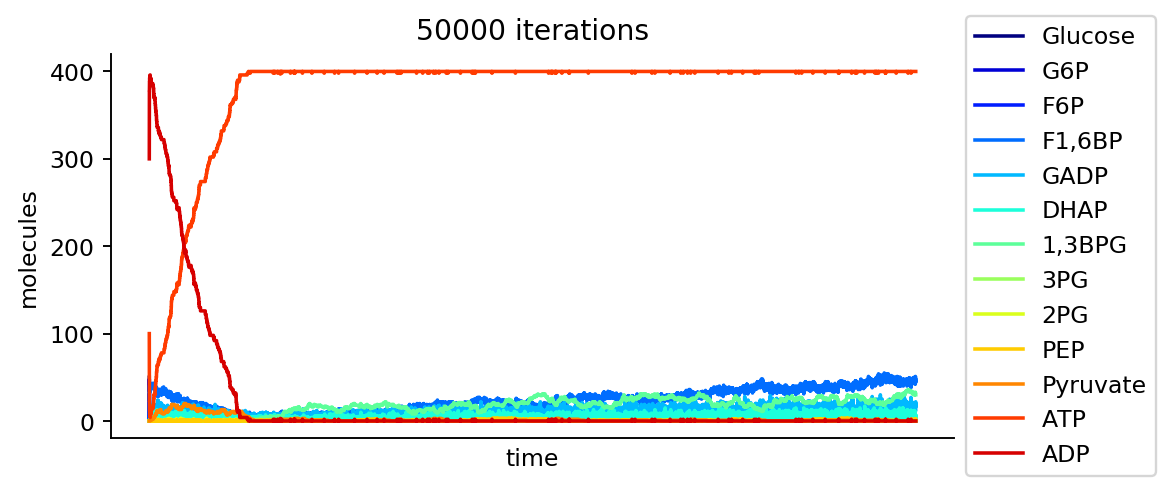

In [364]:
initial = np.matrix(np.array([50,0,0,0,0,0,0,0,0,0,0,100,300]))
iters = 50000
T, V, I = simulate_reactions(initial, reaction_net_3, iters )
plot_simulation(T,V,I, reaction_net_3)

## Stochastic simulation, with flux of Glucose, Pyruvate, ATP, and ADP

In [40]:
# reaction 7 is unidiretional, from lehninger
#                 r1  r2     r-2  r3     r4     r-4    r5     r-5   r6      r6-1    r7    r8     r8-1 r9   r-9   r10
glucose_rate = 0.01
pyruvate_rate = 0.01
ATP_in = 0.0001
ATP_out = 0.0001
ADP_in = 0.001
ADP_out = 0.0001
reaction_rates = [glucose_rate, 30, 2.637, 2.637, 0.047, 0.045, 0.045, 0.379, 0.15, 0.0098, 0.0098, 0.53, 0.733, 0.733, 0.5, 0.04, 21, pyruvate_rate, ATP_in, ATP_out, ADP_in, ADP_out ]
reactants = [
    "Glucose", "G6P", "F6P", "F1,6BP", "GADP", "DHAP",
    "1,3BPG", "3PG", "2PG", "PEP", "Pyruvate", "ATP", "ADP"]
reaction_relations = {
    0: [],
    1: ["Glucose", "ATP"],
    2: ["G6P"],
    3: ["F6P"],
    4: ["F6P", "ATP"],
    5: ["F1,6BP"],
    6: ["GADP", "DHAP"],
    7: ["DHAP"],
    8: ["GADP"],
    9: ["GADP"],
    10:["1,3BPG"],
    11:["1,3BPG", "ADP"],
    12:["3PG"],
    13:["2PG"],
    14:["2PG"],
    15:["PEP"],
    16:["PEP", "ADP"],
    17:["Pyruvate"],
    18:[],
    19:[],
    20:[],
    21:[],
}
A = np.matrix(
    [[1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],  # Glucose
    [0,1,-1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],   # G6P
    [0,0,1,-1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],  # F6P
    [0,0,0,0,1,-1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],   # F1,6BP
    [0,0,0,0,0,1,-1,1,-1,-1,1,0,0,0,0,0,0,0,0,0,0,0], # GADP
    [0,0,0,0,0,1,-1,-1,1,0,0,0,0,0,0,0,0,0,0,0,0,0],  # DHAP
    [0,0,0,0,0,0,0,0,0,1,-1,-1,0,0,0,0,0,0,0,0,0,0],  # 1,3BPG
    [0,0,0,0,0,0,0,0,0,0,0,1,-1,1,0,0,0,0,0,0,0,0],   # 3PG
    [0,0,0,0,0,0,0,0,0,0,0,0,1,-1,-1,1,0,0,0,0,0,0],  # 2PG
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1,-1,0,0,0,0,0],  # PEP
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1,0,0,0,0],   # Pyruvate
    [0,-1,0,0,-1,0,0,0,0,0,0,2,0,0,0,0,2,0,1,-1,0,0],  # ATP
    [0,1,0,0,1,0,0,0,0,0,0,-2,0,0,0,0,-2,0,0,0,1,-1]]  # ADP 
)

reaction_net_4 = {"reactants": reactants,
                  "rates": reaction_rates,
                  "relations": reaction_relations,
                  "stoichiometry": A}

time elapsed: 3.7800819873809814


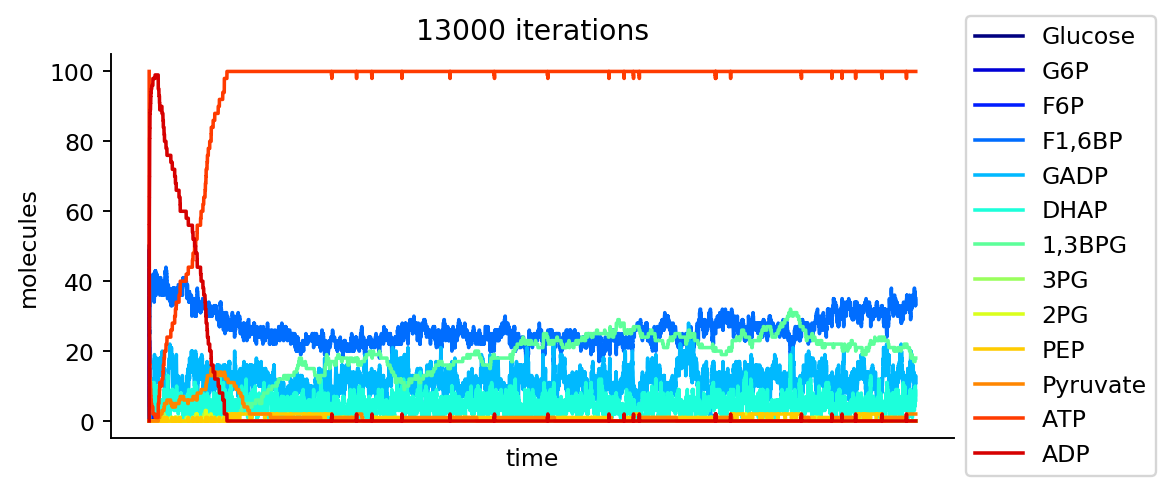

In [17]:
initial = np.matrix(np.array([50,0,0,0,0,0,0,0,0,0,0,100,0]))
iters = 13000
T, V, I = simulate_reactions(initial, reaction_net_4, iters )
plot_simulation(T,V,I, reaction_net_4)

## Run multuple simulations of each model for different initial conditions:


**No ATP model:**


In [13]:
no_ATP_output = []
iters = 50000000
init_glucose = [25*i for i in range(1,21)]   
for starting_glucose in init_glucose:
    init_conditions = [[np.matrix(np.array([starting_glucose,0,0,0,0,0,0,0,0,0,0]))] for n in range(50)]
    with Pool(16) as pool:
        no_ATP_output.append(pool.starmap(simulate_reactions, [[init[0], reaction_net_1, iters] for init in init_conditions]))

In [120]:
#figure out how long it takes for each metabolite to get to zero:
def reactant_start_end_times(model_results, reaction_net):
    start_end_list = []
    for run in model_results:
        start_end = {r:[[-1 for x in run],[-1 for x in run]] for r in reaction_net["reactants"]}
        for k, stuff in enumerate(run):
            T,V,I = stuff
            for i in range(I):
                for j, r in enumerate(reaction_net["reactants"]):

                    #did this reactant appear for the first time?
                    if V[i,j] > 0 and start_end[r][0][k] == -1:
                        start_end[r][0][k] = T[i]

                    #did this reactant disappear?
                    elif V[i,j] == 0 and start_end[r][0][k] > -1 and start_end[r][1][k] == -1:
                        start_end[r][1][k] = T[i]

        start_end_list.append(start_end)
    return start_end_list


In [123]:
def plot_reactant_start_end_times(sel, reactant, ax, end=True):
    
    if end == True:
        data = [se[reactant][1] for se in sel]
    else:
        data = [se[reactant][0] for se in sel]

    violin = ax.violinplot(data, vert=True, showmeans=True);
    for i, v in enumerate(violin['bodies']):
        v.set_edgecolor('k')
        v.set_alpha(0.7)

    # change the line color from blue to black
    for partname in ('cbars','cmins','cmaxes', 'cmeans'):
        vp = violin[partname]
        vp.set_edgecolor('k')
        vp.set_linewidth(1)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

In [121]:
sel = metabolite_start_end_times(with_ATP_output, reaction_net_2)

In [141]:
[2*i-1 for i in range(1,11)]

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19]

[Text(0,0,'5'),
 Text(0,0,'15'),
 Text(0,0,'25'),
 Text(0,0,'35'),
 Text(0,0,'45'),
 Text(0,0,'55'),
 Text(0,0,'65'),
 Text(0,0,'75'),
 Text(0,0,'85'),
 Text(0,0,'95')]

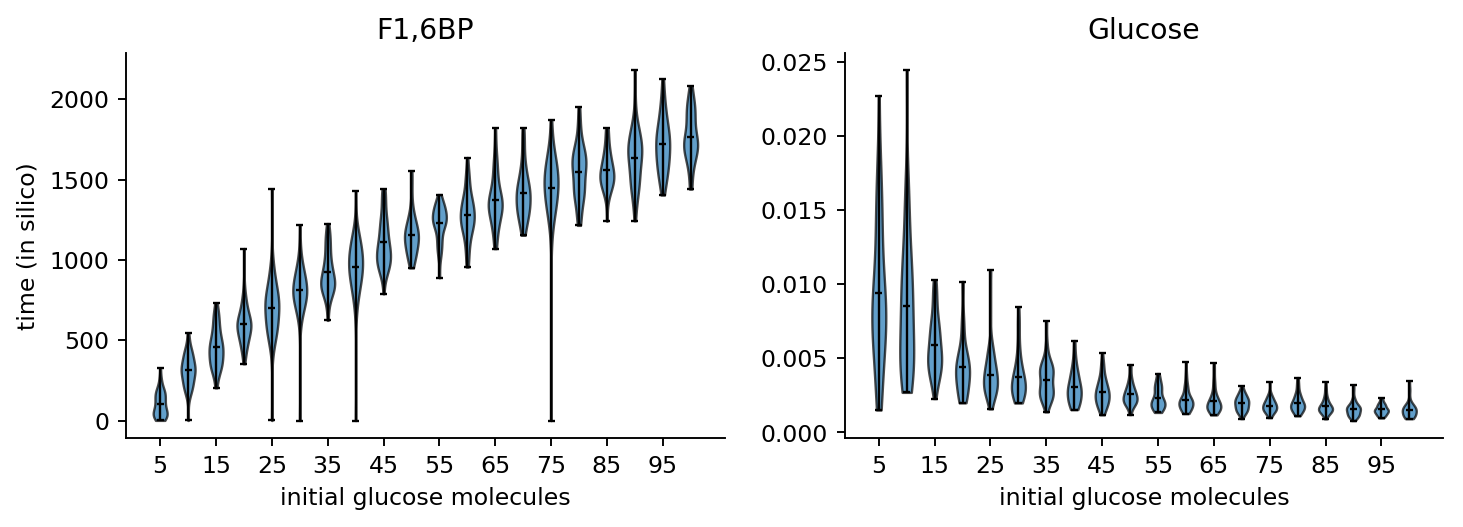

In [144]:
fig, ax = plt.subplots(1,2,figsize=(10,3), dpi=170)    
plot_reactant_start_end_times(sel, "F1,6BP", ax[0])
plot_reactant_start_end_times(sel, "Glucose", ax[1])

#labels:
ax[0].set_title("F1,6BP")
ax[0].set_ylabel("time (in silico)")
ax[0].set_xlabel("initial glucose molecules")
ax[0].set_xticks([2*i-1 for i in range(1,int(len(init_glucose)/2)+1)])
ax[0].set_xticklabels([g for i, g in enumerate(init_glucose) if i % 2 == 0])

ax[1].set_title("Glucose")
ax[1].set_xlabel("initial glucose molecules")
ax[1].set_xticks([2*i-1 for i in range(1,int(len(init_glucose)/2)+1)])
ax[1].set_xticklabels([g for i, g in enumerate(init_glucose) if i % 2 == 0])

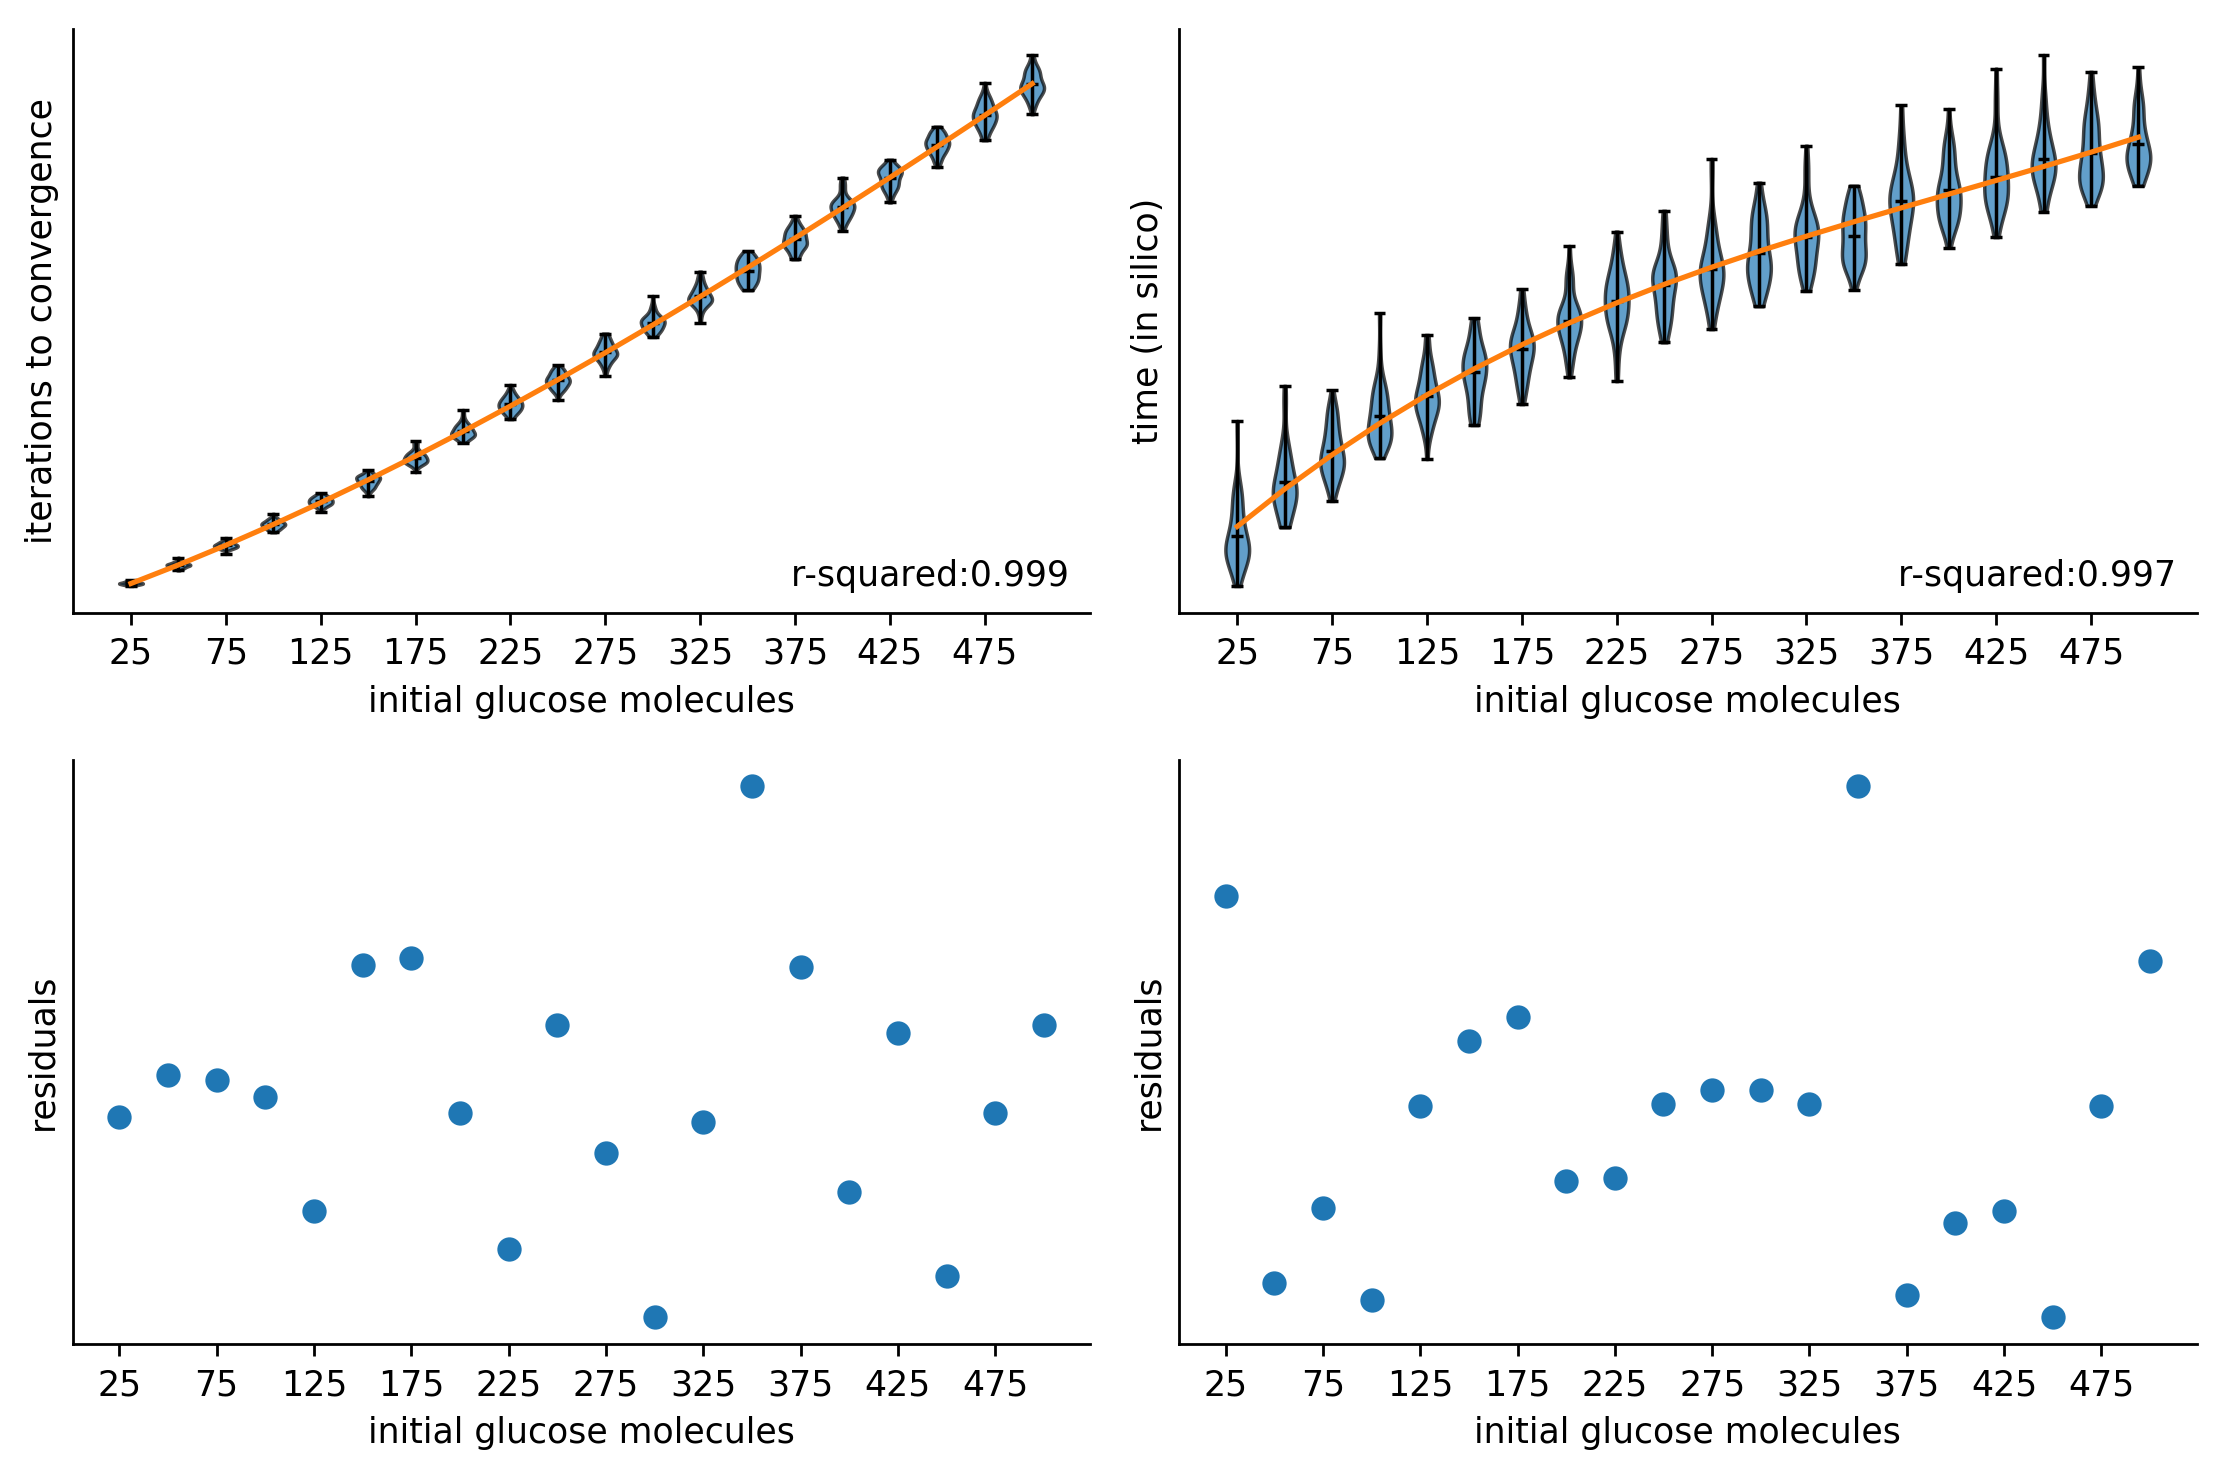

In [21]:
fig, axes = plt.subplots(2,2,figsize=(9,6),dpi=250)
plot_simulations_violin(no_ATP_output, init_glucose, axes[0][0], datatype="iter", poly=3)
plot_simulations_violin(no_ATP_output, init_glucose, axes[0][1], datatype="time", poly=3)

plot_residuals(no_ATP_output, init_glucose, axes[1][0], datatype="iter", poly=3)
plot_residuals(no_ATP_output, init_glucose, axes[1][1], datatype="time", poly=3)
plt.tight_layout()


**With ATP model:**

In [28]:
with_ATP_output = []
iters = 50000000
#init_glucose = [25*i for i in range(1,21)]
init_glucose = [5*i for i in range(1,21)]
for starting_glucose in init_glucose:
    init_conditions = [[np.matrix(np.array([starting_glucose,0,0,0,0,0,0,0,0,0,0,2*starting_glucose,6*starting_glucose]))] for n in range(50)]
    with Pool(16) as pool:
        with_ATP_output.append(pool.starmap(simulate_reactions, [[init[0], reaction_net_2, iters] for init in init_conditions]))

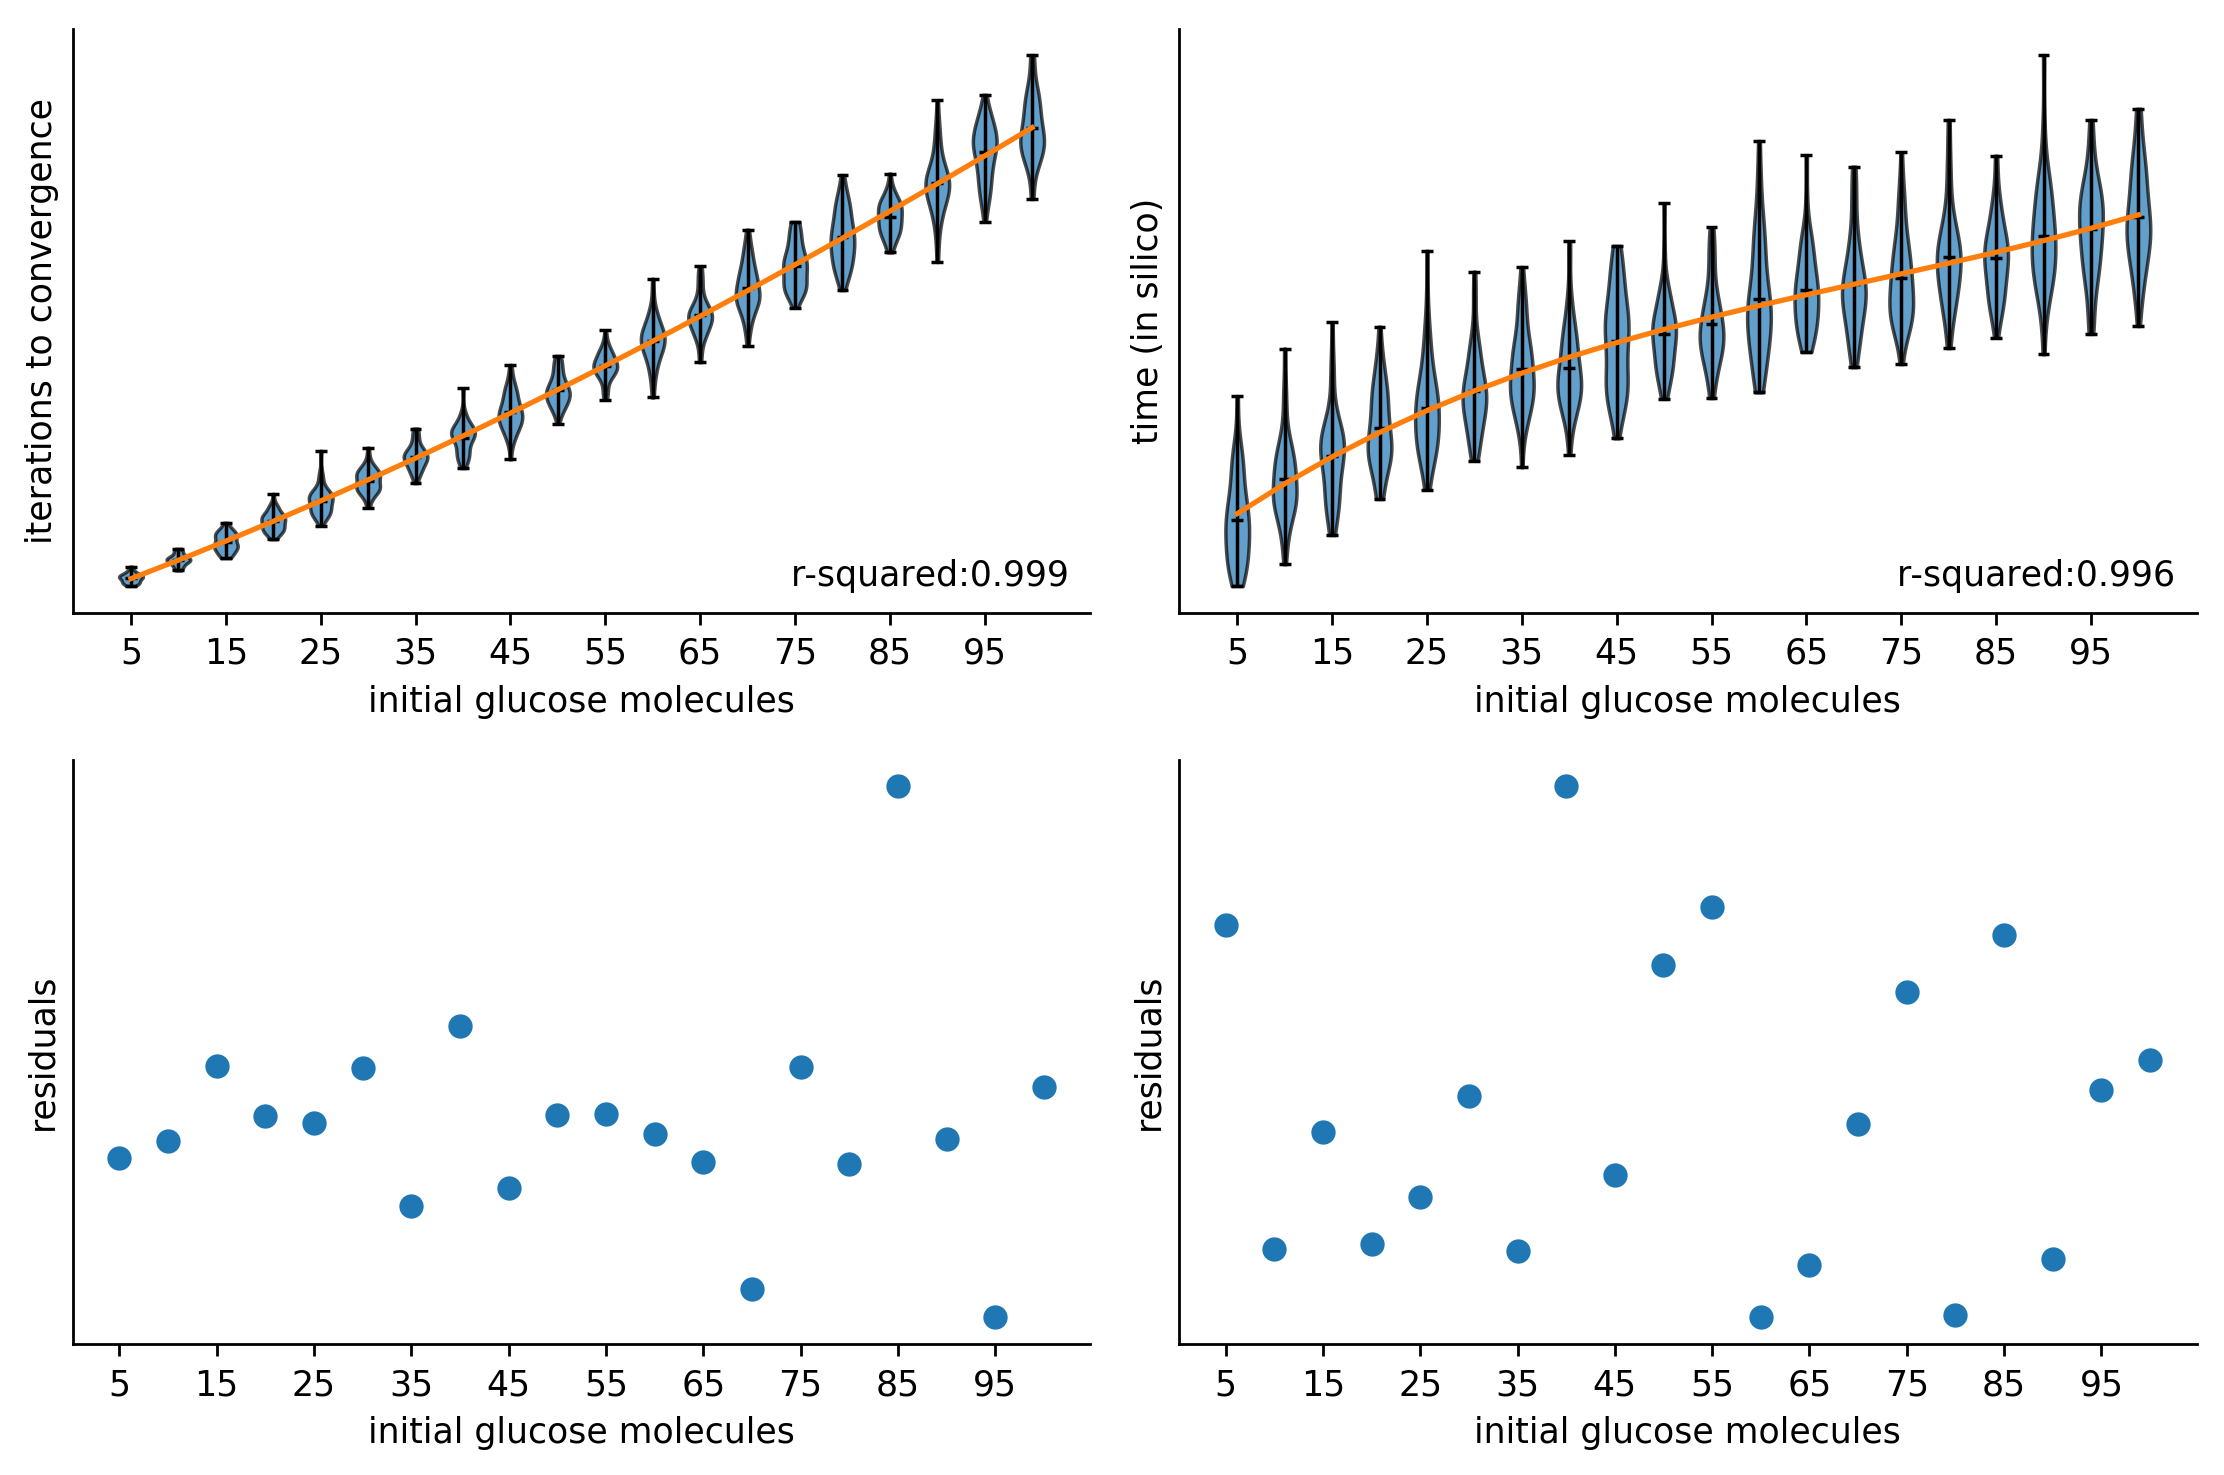

In [29]:
fig, axes = plt.subplots(2,2,figsize=(9,6),dpi=250)
plot_simulations_violin(with_ATP_output, init_glucose, axes[0][0], datatype="iter", poly=3)
plot_simulations_violin(with_ATP_output, init_glucose, axes[0][1], datatype="time", poly=3)

plot_residuals(with_ATP_output, init_glucose, axes[1][0], datatype="iter", poly=3)
plot_residuals(with_ATP_output, init_glucose, axes[1][1], datatype="time", poly=3)
plt.tight_layout()

## Model with Glycogen breakdown (WIP)

In [65]:
# reaction 7 is unidiretional, from lehninger
#                 r1  r2     r-2  r3     r4     r-4    r5     r-5   r6      r6-1    r7    r8     r8-1 r9   r-9   r10
glucose_rate = 0.01
pyruvate_rate = 0.01
ATP_in = 0.1
ATP_out = 0.0001
ADP_in = 0.1
ADP_out = 0.0001
glycogen_in = 0.15
glycogen_out = 0.35
reaction_rates = [glycogen_in, glycogen_out, glucose_rate, 30, 2.637, 1.0, 0.047, 0.045, 0.022, 0.379, 0.15, 0.0098, 0.0049, 0.53, 0.733, 0.4, 0.5, 0.04, 21, pyruvate_rate, ATP_in, ATP_out, ADP_in, ADP_out ]
reactants = [
    "Glycogen", "Glucose", "G6P", "F6P", "F1,6BP", "GADP", "DHAP",
    "1,3BPG", "3PG", "2PG", "PEP", "Pyruvate", "ATP", "ADP"]
reaction_relations = {
    0: [],
    1: ["Glycogen"],
    2: [],
    3: ["Glucose", "ATP"],
    4: ["G6P"],
    5: ["F6P"],
    6: ["F6P", "ATP"],
    7: ["F1,6BP"],
    8: ["GADP", "DHAP"],
    9: ["DHAP"],
    10:["GADP"],
    11:["GADP"],
    12:["1,3BPG"],
    13:["1,3BPG", "ADP"],
    14:["3PG"],
    15:["2PG"],
    16:["2PG"],
    17:["PEP"],
    18:["PEP", "ADP"],
    19:["Pyruvate"],
    20:[],
    21:[],
    22:[],
    23:[],
}
A = np.matrix(
    [[1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,], # Glycogen
    [0,10,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],  # Glucose
    [0,0,0,1,-1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],   # G6P
    [0,0,0,0,1,-1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],  # F6P
    [0,0,0,0,0,0,1,-1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],   # F1,6BP
    [0,0,0,0,0,0,0,1,-1,1,-1,-1,1,0,0,0,0,0,0,0,0,0,0,0], # GADP
    [0,0,0,0,0,0,0,1,-1,-1,1,0,0,0,0,0,0,0,0,0,0,0,0,0],  # DHAP
    [0,0,0,0,0,0,0,0,0,0,0,1,-1,-1,0,0,0,0,0,0,0,0,0,0],  # 1,3BPG
    [0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1,1,0,0,0,0,0,0,0,0],   # 3PG
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1,-1,1,0,0,0,0,0,0],  # 2PG
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1,-1,0,0,0,0,0],  # PEP
    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1,0,0,0,0],   # Pyruvate
    [0,0,0,-1,0,0,-1,0,0,0,0,0,0,2,0,0,0,0,2,0,1,-1,0,0],  # ATP
    [0,00,0,1,0,0,1,0,0,0,0,0,0,-2,0,0,0,0,-2,0,0,0,1,-1]]  # ADP 
)

reaction_net_5 = {"reactants": reactants,
                  "rates": reaction_rates,
                  "relations": reaction_relations,
                  "stoichiometry": A}

time elapsed: 2.1123456954956055


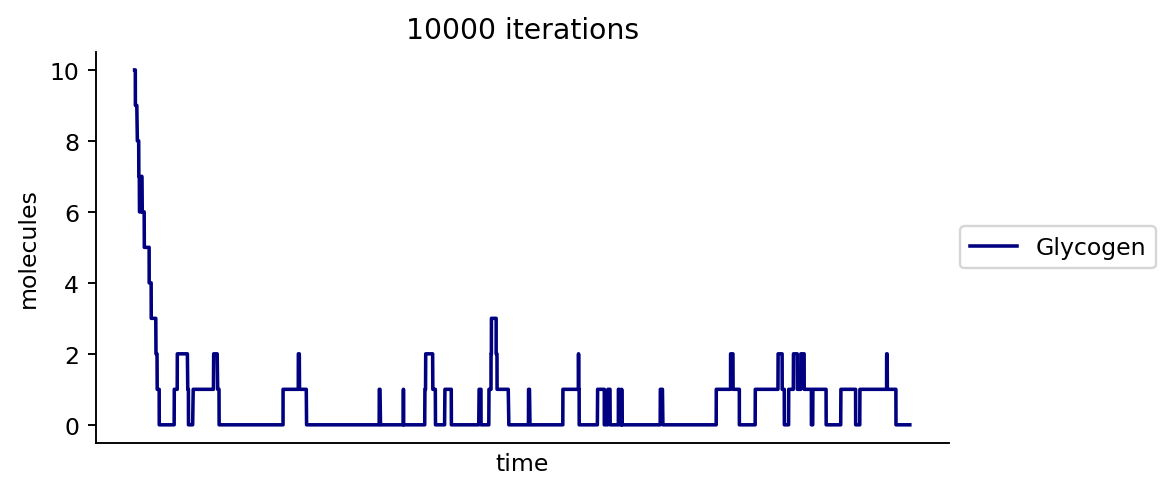

In [71]:
initial = np.matrix(np.array([10,10,0,0,0,0,0,0,0,0,0,0,500,100]))
iters = 10000
T, V, I = simulate_reactions(initial, reaction_net_5, iters )
plot_simulation(T,V,I, reaction_net_5, metabolites=["Glycogen"])

